In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 15:37 - loss: 0.1907 - STD: 2.0039e-04 - MAE: 0.4260

 11/793 [..............................] - ETA: 4s - loss: 0.0415 - STD: 2.6555e-04 - MAE: 0.1604   

 20/793 [..............................] - ETA: 4s - loss: 0.0355 - STD: 1.5730e-04 - MAE: 0.1501

 28/793 [>.............................] - ETA: 4s - loss: 0.0289 - STD: 1.3451e-04 - MAE: 0.1312

 36/793 [>.............................] - ETA: 4s - loss: 0.0250 - STD: 1.2189e-04 - MAE: 0.1221

 45/793 [>.............................] - ETA: 4s - loss: 0.0220 - STD: 1.0534e-04 - MAE: 0.1127

 54/793 [=>............................] - ETA: 4s - loss: 0.0199 - STD: 9.4749e-05 - MAE: 0.1064

 63/793 [=>............................] - ETA: 4s - loss: 0.0184 - STD: 8.8294e-05 - MAE: 0.1022

 72/793 [=>............................] - ETA: 4s - loss: 0.0172 - STD: 8.4397e-05 - MAE: 0.0986

 80/793 [==>...........................] - ETA: 4s - loss: 0.0164 - STD: 8.2922e-05 - MAE: 0.0963

 89/793 [==>...........................] - ETA: 4s - loss: 0.0157 - STD: 8.2993e-05 - MAE: 0.0942

 98/793 [==>...........................] - ETA: 4s - loss: 0.0151 - STD: 8.4650e-05 - MAE: 0.0924

107/793 [===>..........................] - ETA: 4s - loss: 0.0146 - STD: 8.8326e-05 - MAE: 0.0911

116/793 [===>..........................] - ETA: 4s - loss: 0.0142 - STD: 9.3715e-05 - MAE: 0.0898

124/793 [===>..........................] - ETA: 4s - loss: 0.0139 - STD: 1.0054e-04 - MAE: 0.0890

133/793 [====>.........................] - ETA: 3s - loss: 0.0136 - STD: 1.1080e-04 - MAE: 0.0881

142/793 [====>.........................] - ETA: 3s - loss: 0.0133 - STD: 1.2488e-04 - MAE: 0.0873

151/793 [====>.........................] - ETA: 3s - loss: 0.0131 - STD: 1.4407e-04 - MAE: 0.0867

160/793 [=====>........................] - ETA: 3s - loss: 0.0129 - STD: 1.7062e-04 - MAE: 0.0862

169/793 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 2.0735e-04 - MAE: 0.0856

177/793 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 2.5488e-04 - MAE: 0.0851

183/793 [=====>........................] - ETA: 3s - loss: 0.0124 - STD: 3.0264e-04 - MAE: 0.0848

192/793 [======>.......................] - ETA: 3s - loss: 0.0123 - STD: 4.0399e-04 - MAE: 0.0843

201/793 [======>.......................] - ETA: 3s - loss: 0.0121 - STD: 5.5932e-04 - MAE: 0.0839

210/793 [======>.......................] - ETA: 3s - loss: 0.0120 - STD: 8.0130e-04 - MAE: 0.0835

218/793 [=======>......................] - ETA: 3s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0831    

225/793 [=======>......................] - ETA: 3s - loss: 0.0117 - STD: 0.0015 - MAE: 0.0827

230/793 [=======>......................] - ETA: 4s - loss: 0.0116 - STD: 0.0018 - MAE: 0.0825

241/793 [========>.....................] - ETA: 4s - loss: 0.0115 - STD: 0.0028 - MAE: 0.0819

250/793 [========>.....................] - ETA: 4s - loss: 0.0113 - STD: 0.0038 - MAE: 0.0814

259/793 [========>.....................] - ETA: 4s - loss: 0.0112 - STD: 0.0049 - MAE: 0.0809

268/793 [=========>....................] - ETA: 4s - loss: 0.0110 - STD: 0.0059 - MAE: 0.0804

277/793 [=========>....................] - ETA: 4s - loss: 0.0109 - STD: 0.0070 - MAE: 0.0800

285/793 [=========>....................] - ETA: 4s - loss: 0.0108 - STD: 0.0079 - MAE: 0.0796

291/793 [==========>...................] - ETA: 4s - loss: 0.0107 - STD: 0.0086 - MAE: 0.0793

300/793 [==========>...................] - ETA: 4s - loss: 0.0106 - STD: 0.0095 - MAE: 0.0788

309/793 [==========>...................] - ETA: 3s - loss: 0.0105 - STD: 0.0104 - MAE: 0.0785

318/793 [===========>..................] - ETA: 3s - loss: 0.0104 - STD: 0.0113 - MAE: 0.0780

326/793 [===========>..................] - ETA: 3s - loss: 0.0103 - STD: 0.0121 - MAE: 0.0777

333/793 [===========>..................] - ETA: 3s - loss: 0.0102 - STD: 0.0128 - MAE: 0.0773

338/793 [===========>..................] - ETA: 3s - loss: 0.0102 - STD: 0.0132 - MAE: 0.0771

344/793 [============>.................] - ETA: 3s - loss: 0.0101 - STD: 0.0138 - MAE: 0.0768

350/793 [============>.................] - ETA: 3s - loss: 0.0100 - STD: 0.0144 - MAE: 0.0766

358/793 [============>.................] - ETA: 3s - loss: 0.0100 - STD: 0.0152 - MAE: 0.0762

367/793 [============>.................] - ETA: 3s - loss: 0.0099 - STD: 0.0161 - MAE: 0.0757

376/793 [=============>................] - ETA: 3s - loss: 0.0098 - STD: 0.0170 - MAE: 0.0753

385/793 [=============>................] - ETA: 3s - loss: 0.0097 - STD: 0.0179 - MAE: 0.0749

394/793 [=============>................] - ETA: 3s - loss: 0.0096 - STD: 0.0188 - MAE: 0.0745

403/793 [==============>...............] - ETA: 3s - loss: 0.0095 - STD: 0.0197 - MAE: 0.0741

412/793 [==============>...............] - ETA: 2s - loss: 0.0094 - STD: 0.0205 - MAE: 0.0737

419/793 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 0.0211 - MAE: 0.0734

426/793 [===============>..............] - ETA: 2s - loss: 0.0093 - STD: 0.0218 - MAE: 0.0731

435/793 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 0.0226 - MAE: 0.0727

444/793 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0233 - MAE: 0.0723

453/793 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.0241 - MAE: 0.0719

460/793 [================>.............] - ETA: 2s - loss: 0.0089 - STD: 0.0246 - MAE: 0.0717

466/793 [================>.............] - ETA: 2s - loss: 0.0089 - STD: 0.0251 - MAE: 0.0714

471/793 [================>.............] - ETA: 2s - loss: 0.0088 - STD: 0.0255 - MAE: 0.0712

476/793 [=================>............] - ETA: 2s - loss: 0.0088 - STD: 0.0259 - MAE: 0.0710

483/793 [=================>............] - ETA: 2s - loss: 0.0087 - STD: 0.0265 - MAE: 0.0708

491/793 [=================>............] - ETA: 2s - loss: 0.0087 - STD: 0.0272 - MAE: 0.0705

500/793 [=================>............] - ETA: 2s - loss: 0.0086 - STD: 0.0278 - MAE: 0.0701

509/793 [==================>...........] - ETA: 2s - loss: 0.0085 - STD: 0.0285 - MAE: 0.0698

517/793 [==================>...........] - ETA: 2s - loss: 0.0085 - STD: 0.0291 - MAE: 0.0695

525/793 [==================>...........] - ETA: 2s - loss: 0.0084 - STD: 0.0296 - MAE: 0.0692

534/793 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0302 - MAE: 0.0689

542/793 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0307 - MAE: 0.0686

549/793 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0311 - MAE: 0.0684

558/793 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0317 - MAE: 0.0681

567/793 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0322 - MAE: 0.0678

576/793 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0328 - MAE: 0.0675

585/793 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.0333 - MAE: 0.0672

594/793 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0339 - MAE: 0.0670

603/793 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0343 - MAE: 0.0668

611/793 [======================>.......] - ETA: 1s - loss: 0.0079 - STD: 0.0347 - MAE: 0.0666

617/793 [======================>.......] - ETA: 1s - loss: 0.0078 - STD: 0.0350 - MAE: 0.0665

626/793 [======================>.......] - ETA: 1s - loss: 0.0078 - STD: 0.0354 - MAE: 0.0663

635/793 [=======================>......] - ETA: 1s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0660

644/793 [=======================>......] - ETA: 1s - loss: 0.0077 - STD: 0.0362 - MAE: 0.0658

652/793 [=======================>......] - ETA: 1s - loss: 0.0077 - STD: 0.0366 - MAE: 0.0656

659/793 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0369 - MAE: 0.0654

664/793 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0372 - MAE: 0.0653

669/793 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0374 - MAE: 0.0652

675/793 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0377 - MAE: 0.0650

683/793 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0381 - MAE: 0.0648

692/793 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0384 - MAE: 0.0646

701/793 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0388 - MAE: 0.0643

710/793 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0392 - MAE: 0.0641

719/793 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0396 - MAE: 0.0639

728/793 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0400 - MAE: 0.0637

737/793 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0403 - MAE: 0.0635

746/793 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0633

752/793 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0409 - MAE: 0.0632

760/793 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0412 - MAE: 0.0630

769/793 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0416 - MAE: 0.0628

778/793 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0419 - MAE: 0.0627

787/793 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0625

793/793 [==============================] - 8s 8ms/step - loss: 0.0070 - STD: 0.0424 - MAE: 0.0624 - val_loss: 0.0039 - val_STD: 0.0526 - val_MAE: 0.0446


Epoch 2/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0040 - STD: 0.0636 - MAE: 0.0447

 10/793 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0710 - MAE: 0.0482 

 18/793 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0481

 27/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

 36/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0476

 43/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0472

 51/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0470

 60/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

 69/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

 77/793 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

 85/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0466

 90/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0466

 95/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

100/793 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

107/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

116/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

125/793 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

134/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

143/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

152/793 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

160/793 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

168/793 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

175/793 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

183/793 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

190/793 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

198/793 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

205/793 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

213/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

220/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

227/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

235/793 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

243/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

251/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

260/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0464

269/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0463

277/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0463

285/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463

293/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463

301/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

310/793 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463

319/793 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463

328/793 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

337/793 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

346/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0462

355/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

364/793 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

372/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

381/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

390/793 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

399/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

407/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

416/793 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

424/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

432/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

440/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

448/793 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

456/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

464/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

473/793 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

481/793 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

490/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

499/793 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

508/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

516/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

524/793 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

533/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

539/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

543/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

552/793 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

561/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

569/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

577/793 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

586/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

594/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

602/793 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

610/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

618/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

625/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

632/793 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

640/793 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

648/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

655/793 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

663/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

671/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

678/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

686/793 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

693/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

701/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

709/793 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

717/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

724/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

731/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

739/793 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

746/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

754/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

762/793 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

769/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

776/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

784/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

792/793 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

793/793 [==============================] - 6s 7ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453 - val_loss: 0.0033 - val_STD: 0.0542 - val_MAE: 0.0413


Epoch 3/10000


  1/793 [..............................] - ETA: 27s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0433

  8/793 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0444 

 15/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 22/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

 29/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

 37/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

 44/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

 51/793 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 59/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

 68/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 77/793 [=>............................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 85/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 94/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

103/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

111/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

120/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

129/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

137/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

145/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

153/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

161/793 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

169/793 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0442

178/793 [=====>........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

187/793 [======>.......................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

196/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

205/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

214/793 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

222/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

231/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

240/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

247/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

256/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

265/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

274/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

282/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

290/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

298/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

307/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

316/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

325/793 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

334/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

343/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

352/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

361/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

369/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

378/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

387/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

395/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

404/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

413/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

422/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

431/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

439/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

447/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

456/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

465/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

474/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

482/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

491/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

500/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

509/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

518/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

526/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

535/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

544/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

553/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

562/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

571/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

579/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

588/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

597/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

606/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

615/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

623/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

632/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

641/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

650/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

659/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

667/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

676/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

685/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

694/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

703/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

711/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

718/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

726/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

735/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

744/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

753/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

762/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

770/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

779/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

788/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

793/793 [==============================] - 5s 7ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435 - val_loss: 0.0030 - val_STD: 0.0612 - val_MAE: 0.0401


Epoch 4/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0432

  8/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429 

 17/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0426

 26/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

 35/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

 44/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 52/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0425

 60/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 69/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 78/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 87/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

 96/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

104/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

113/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

122/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

131/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

140/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

149/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

156/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

165/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

174/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

183/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

192/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

200/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

209/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

218/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

227/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

236/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

245/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

252/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

260/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

269/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

278/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

287/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

296/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

303/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

312/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

321/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

330/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

339/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

347/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

355/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

364/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

373/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

382/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

390/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

399/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

408/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

417/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

426/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

435/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

443/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

452/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

461/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

470/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

479/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

487/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

495/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

504/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

513/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

522/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

531/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

539/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

548/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

557/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

566/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

574/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

582/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

590/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

599/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

608/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

617/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

626/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

633/793 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

642/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

651/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

660/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

669/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

677/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

685/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

694/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

702/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

710/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

719/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

727/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

743/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

752/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

761/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

769/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

778/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

787/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

793/793 [==============================] - 5s 7ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423 - val_loss: 0.0036 - val_STD: 0.0550 - val_MAE: 0.0424


Epoch 5/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0445

  9/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0738 - MAE: 0.0425 

 17/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0421

 26/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

 35/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

 44/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 52/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0417

 60/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 69/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 78/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 87/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 96/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

104/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

113/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

122/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

131/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

139/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

148/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

156/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

165/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

174/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

183/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

192/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

201/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

209/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

218/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

227/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

236/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

245/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

253/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

262/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

271/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

280/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

289/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

297/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

306/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

315/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

324/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

333/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

342/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

350/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

359/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

368/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

377/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

386/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

394/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

402/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

411/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

420/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

429/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

437/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

446/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

455/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

464/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

473/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

481/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

490/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

499/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

508/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

517/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

525/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

534/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

551/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

560/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

569/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

577/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

621/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

630/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

638/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

647/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

656/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

664/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

673/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

682/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

691/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

700/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

708/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

715/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

723/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

732/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

741/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

750/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

758/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

767/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

776/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

785/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

793/793 [==============================] - 5s 7ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415 - val_loss: 0.0031 - val_STD: 0.0590 - val_MAE: 0.0396


Epoch 6/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0397

  9/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0420 

 18/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0436

 26/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

 35/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 44/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 52/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

 61/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 70/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 79/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

 88/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 96/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

105/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

114/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

123/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

132/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

141/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

149/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

158/793 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

167/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

176/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

185/793 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

194/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

202/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

211/793 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

220/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

229/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

238/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

246/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

255/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

264/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

273/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

282/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

291/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

299/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

308/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

317/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

326/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

335/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

343/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

351/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

360/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

369/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

378/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

387/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

395/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

404/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

413/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

422/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

431/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

439/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

448/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

457/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

466/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

475/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

483/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

492/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

501/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

510/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

519/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

527/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

536/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

545/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

554/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

562/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

571/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

579/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

588/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

597/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

606/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

615/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

623/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

632/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

641/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

650/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

659/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

668/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

675/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

684/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

693/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

702/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

711/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

727/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

736/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

745/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

754/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

763/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

771/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

780/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

789/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0585 - val_MAE: 0.0389


Epoch 7/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0396

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 

 19/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

 26/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 43/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 52/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

 61/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 68/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 75/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 84/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

 93/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

102/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

111/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

119/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

128/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

137/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

146/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

155/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

164/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

172/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

180/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

189/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

198/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

207/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

215/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

223/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

232/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

241/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

250/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

258/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

266/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

275/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

284/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

293/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

301/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

310/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

319/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

328/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

337/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

354/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

363/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

372/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

381/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

389/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

398/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

407/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

416/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

425/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

434/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

441/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

449/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

458/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

467/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

476/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

484/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

492/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

501/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

510/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

518/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

526/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

535/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

544/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

553/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

562/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

570/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

579/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

588/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

597/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

606/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

615/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

623/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

632/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

641/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

650/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

658/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

665/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

674/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

683/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

692/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

701/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

709/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

717/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

726/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

735/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

743/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

752/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

760/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

769/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

778/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

786/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

793/793 [==============================] - 5s 7ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0610 - val_MAE: 0.0383


Epoch 8/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0381

  8/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0817 - MAE: 0.0392 

 16/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0390

 24/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0393

 33/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0395

 42/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

 51/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 59/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399

 68/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

 77/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 86/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

 95/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

103/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

112/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

139/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

147/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

156/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

165/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

173/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

182/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

189/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

198/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

207/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

216/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

225/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

233/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

241/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

250/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

259/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

268/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

277/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

286/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

294/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

303/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

312/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

321/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

329/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

337/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

345/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

353/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

362/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

371/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

379/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

387/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

396/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

405/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

414/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

423/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

430/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

438/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

447/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

456/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

465/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

473/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

481/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

489/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

498/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

507/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

516/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

524/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

533/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

542/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

551/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

560/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

568/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

576/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

589/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

598/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

607/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

616/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

624/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

630/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

635/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

640/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

647/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

656/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

665/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

674/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

683/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

692/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

701/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

710/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

719/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

726/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

735/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

744/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

753/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

762/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

771/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

780/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

789/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0659 - val_MAE: 0.0385


Epoch 9/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0030 - STD: 0.0871 - MAE: 0.0404

  6/793 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0407 

 11/793 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 19/793 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 28/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 37/793 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 46/793 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 55/793 [=>............................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 64/793 [=>............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 72/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 79/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

 85/793 [==>...........................] - ETA: 5s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 93/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

102/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

111/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

119/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

125/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

135/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

142/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

150/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

159/793 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

168/793 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

177/793 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

186/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

195/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

203/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

210/793 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

219/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

227/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

235/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

244/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

253/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

262/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

270/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

276/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

285/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

294/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

303/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

311/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

317/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

322/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

327/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

333/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

341/793 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

350/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

359/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

368/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

376/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

385/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

393/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

400/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

406/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

414/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

423/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

432/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

440/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

446/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

451/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

456/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

463/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

471/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

480/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

489/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

498/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

506/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

515/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

523/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

530/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

538/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

547/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

556/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

573/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

581/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

590/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

599/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

608/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

617/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

623/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

631/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

640/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

649/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

657/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

665/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

670/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

681/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

689/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

698/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

707/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

716/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

724/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

733/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

742/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

750/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

766/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

774/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

781/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

789/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

793/793 [==============================] - 6s 7ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0629 - val_MAE: 0.0380


Epoch 10/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0840 - MAE: 0.0392

  9/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385 

 17/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0787 - MAE: 0.0383

 25/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0786 - MAE: 0.0385

 34/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0788 - MAE: 0.0384

 42/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0384

 51/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

 59/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 68/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

 76/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

 85/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 94/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

102/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

110/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

118/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

126/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

134/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

142/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

151/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

160/793 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

169/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

178/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

187/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

195/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

204/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

213/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

222/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

229/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

234/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

242/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

251/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

256/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

265/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

273/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

281/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

289/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

298/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

306/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

314/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

322/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

330/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

337/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

344/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

351/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

358/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

365/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

372/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

379/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

386/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

393/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

400/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

408/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

415/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

423/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

430/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

438/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

445/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

452/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

459/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

466/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

473/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

480/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

487/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

495/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

502/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

510/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

517/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

524/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

531/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

538/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

545/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

552/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

559/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

566/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

573/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

581/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

588/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

595/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

602/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

609/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

615/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

621/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

627/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

633/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

640/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

647/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

654/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

661/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

668/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

675/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

683/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

690/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

697/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

704/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

711/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

718/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

726/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

734/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

742/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

750/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

758/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

766/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

774/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

782/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

791/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

793/793 [==============================] - 6s 7ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386 - val_loss: 0.0026 - val_STD: 0.0640 - val_MAE: 0.0377


Epoch 11/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0383

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391 

 19/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

 27/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0406

 35/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 60/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

 69/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

 78/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

 87/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

 96/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

105/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

112/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

120/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

129/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

137/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

146/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

155/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

164/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

173/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

182/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

190/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

198/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

207/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

215/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

223/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

232/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

241/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

250/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

259/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

268/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

276/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

284/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

292/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

301/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

309/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

318/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

327/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

336/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

344/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

351/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

359/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

368/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

377/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

385/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

393/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

401/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

410/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

419/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

428/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

437/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

445/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

454/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

463/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

472/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

481/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

489/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

498/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

507/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

516/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

525/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

533/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

541/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

549/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

558/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

567/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

576/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

585/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

593/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

602/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

611/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

620/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

629/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

637/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

646/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

655/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

663/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

679/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

688/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

697/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

706/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

715/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

723/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

731/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

740/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

749/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

758/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

767/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

775/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

783/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

792/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381 - val_loss: 0.0028 - val_STD: 0.0656 - val_MAE: 0.0399


Epoch 12/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0850 - MAE: 0.0407

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0390 

 18/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

 27/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0377

 36/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

 45/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

 53/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

 62/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

 70/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

 79/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

 86/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

 95/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

104/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

113/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

121/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

130/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

148/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

157/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

165/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

174/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

183/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

192/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

201/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

209/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

218/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

227/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

236/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

245/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

254/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

262/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

271/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

280/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

289/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

298/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

306/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

314/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

322/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

331/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

340/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

348/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

356/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

365/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

374/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

383/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

392/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

400/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

409/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

418/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

427/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

436/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

444/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

453/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

462/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

471/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

480/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

489/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

497/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

506/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

515/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

524/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

533/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

542/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

549/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

558/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

567/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

576/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

585/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

593/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

602/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

611/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

620/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

629/793 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

638/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

646/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

655/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

673/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

682/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

690/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

699/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

708/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

717/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

726/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

734/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

742/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

751/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

785/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377 - val_loss: 0.0028 - val_STD: 0.0619 - val_MAE: 0.0379


Epoch 13/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0358

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0813 - MAE: 0.0385 

 19/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0385

 28/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0384

 36/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

 45/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 54/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 63/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

 72/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

 80/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 88/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

 97/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

115/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

124/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

141/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

150/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

159/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

167/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

175/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

184/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

193/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

202/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0378

210/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

218/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

227/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

236/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

245/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

254/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

262/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

271/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

280/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

289/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

298/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

306/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

315/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

324/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

333/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

342/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

351/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

359/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

368/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

377/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

386/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

395/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

403/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

412/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

421/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

430/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

439/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

447/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

456/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

465/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

474/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

483/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

491/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

500/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

509/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

518/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

527/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

535/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

544/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

553/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

562/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

571/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

579/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

588/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

597/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

606/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

615/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

624/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

631/793 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

640/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

649/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

658/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

667/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

675/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

684/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

693/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

702/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

711/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

719/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

727/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

736/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

745/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

754/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

763/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

771/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

780/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

789/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373 - val_loss: 0.0029 - val_STD: 0.0601 - val_MAE: 0.0379


Epoch 14/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.0775 - MAE: 0.0365

  9/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0372 

 17/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0371

 26/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

 44/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

 53/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

 61/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

 70/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

 79/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

 88/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

 97/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

105/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

113/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

122/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

131/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

140/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

148/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

156/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

165/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

174/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

183/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

191/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

200/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

209/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

218/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

227/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

235/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

244/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

253/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

262/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

271/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

279/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

288/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

296/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

305/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

314/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

322/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

330/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

339/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

348/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

357/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

366/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

374/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

383/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

392/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

401/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

410/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

418/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

427/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

436/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

445/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

454/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

461/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

470/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

479/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

488/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

497/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

505/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

513/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

521/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

530/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

539/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

547/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

555/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

564/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

573/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

581/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

590/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

598/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

607/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

616/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

625/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

633/793 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

641/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

650/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

659/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

668/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

676/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

691/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

700/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

709/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

751/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

760/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

768/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369 - val_loss: 0.0027 - val_STD: 0.0662 - val_MAE: 0.0378


Epoch 15/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0024 - STD: 0.0841 - MAE: 0.0356

  9/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0797 - MAE: 0.0360 

 17/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0363

 26/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0364

 35/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 60/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

 95/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

104/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

113/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

122/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

131/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

139/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

148/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

157/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

166/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

175/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

183/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

192/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

201/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

210/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

218/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

226/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

234/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

243/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

252/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

261/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

269/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

278/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

286/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

295/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

313/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

322/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

331/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

338/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

347/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

356/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

365/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

374/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

381/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

389/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

397/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

406/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

415/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

423/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

431/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

440/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

449/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

457/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

465/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

473/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

482/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

491/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

500/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

509/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

517/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

526/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

535/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

544/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

553/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

561/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

570/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

579/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

588/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

597/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

605/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

631/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

640/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

648/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

657/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

666/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

674/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

683/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

691/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

699/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

708/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

726/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

742/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

751/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

760/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

778/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365 - val_loss: 0.0030 - val_STD: 0.0575 - val_MAE: 0.0386


Epoch 16/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0397

  9/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0796 - MAE: 0.0363 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0803 - MAE: 0.0359

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0811 - MAE: 0.0361

 35/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

 51/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 60/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 86/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

 94/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0361

103/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

112/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

121/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0362

129/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

138/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

147/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

156/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

165/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

173/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

181/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

189/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

198/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

207/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

215/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

223/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

232/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

240/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

249/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

257/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

265/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

274/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

283/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

292/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

301/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

309/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

316/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

324/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

333/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

349/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

358/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

375/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

383/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

391/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

399/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

407/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

415/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

423/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

429/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

436/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

444/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

453/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

462/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

470/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

476/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

481/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

486/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

493/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

501/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

510/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

519/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

527/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

535/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

543/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

552/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

559/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

567/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

576/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

584/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

593/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

602/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

610/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

618/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

627/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

636/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

645/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

654/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

663/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

672/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

680/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

688/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

694/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

703/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

712/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

721/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

729/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

735/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

740/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

745/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

751/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

759/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

768/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

777/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

786/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

793/793 [==============================] - 6s 7ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361 - val_loss: 0.0026 - val_STD: 0.0654 - val_MAE: 0.0371


Epoch 17/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0852 - MAE: 0.0346

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0356 

 17/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

 25/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

 32/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0357

 37/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

 42/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

 48/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

 56/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

 65/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

 74/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

 82/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0357

 91/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

100/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

109/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0358

116/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

123/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

131/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

140/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

149/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

158/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

167/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

176/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

185/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

194/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

203/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

212/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

230/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

239/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

248/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

257/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

266/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

275/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

283/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

289/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

296/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

305/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

314/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

323/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

331/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

336/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

341/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

346/793 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

354/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

362/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

370/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

379/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

388/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

397/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

406/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

414/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

421/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

427/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

436/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

445/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

454/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

462/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

469/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

474/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

479/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

485/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

493/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

502/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

511/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

520/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

529/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

538/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

547/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

554/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

562/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

571/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

580/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

589/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

598/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

607/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

616/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

625/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

634/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

643/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

652/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

661/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

670/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

678/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

684/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

692/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

701/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

710/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

718/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

726/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

731/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0357

736/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

741/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

748/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

757/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

766/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

775/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

784/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

793/793 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

793/793 [==============================] - 6s 7ms/step - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356 - val_loss: 0.0027 - val_STD: 0.0684 - val_MAE: 0.0378


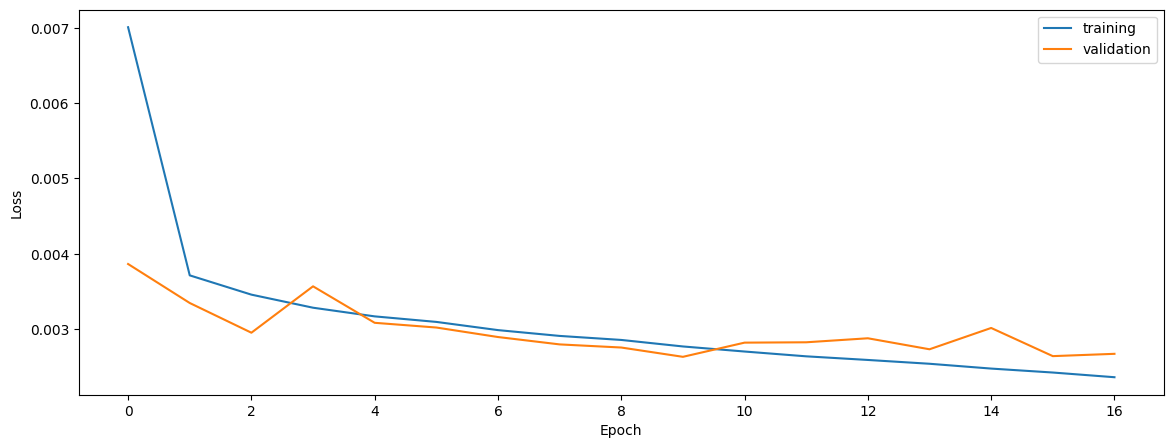

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8457587715473041
0.8350902571942393
0.8216146810995296


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8462334107325837
0.8490049082296173
0.8293375048576404


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8442477607931237
0.8453030816636726
0.8262347930876288


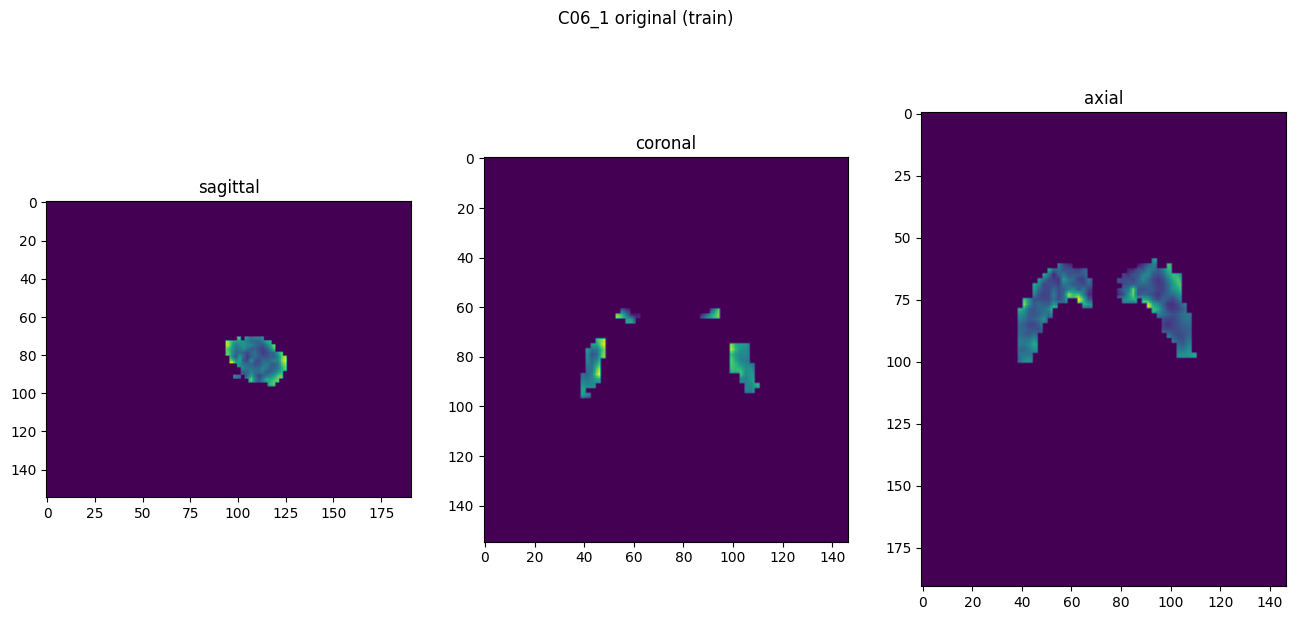

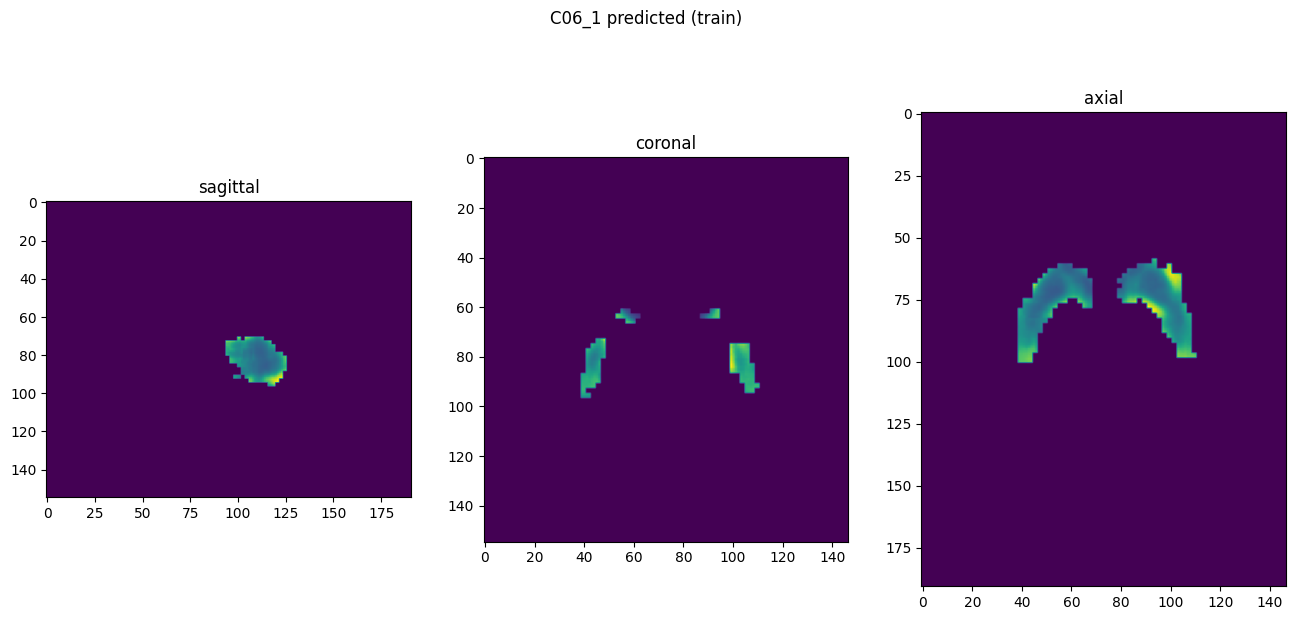

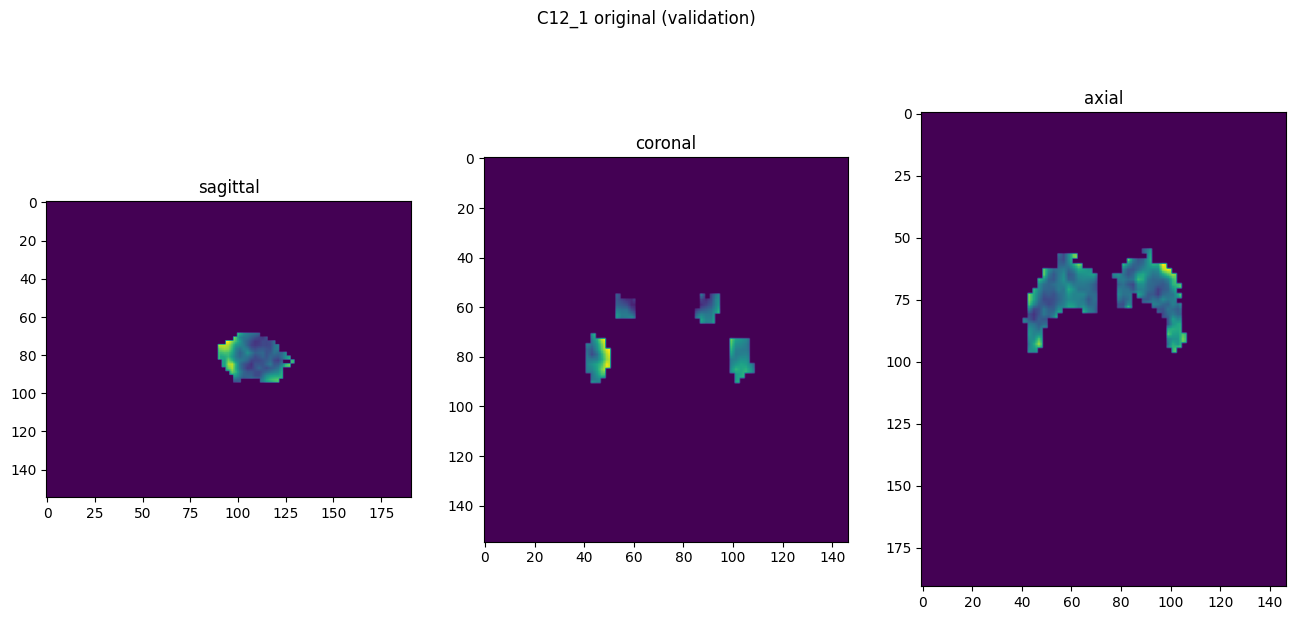

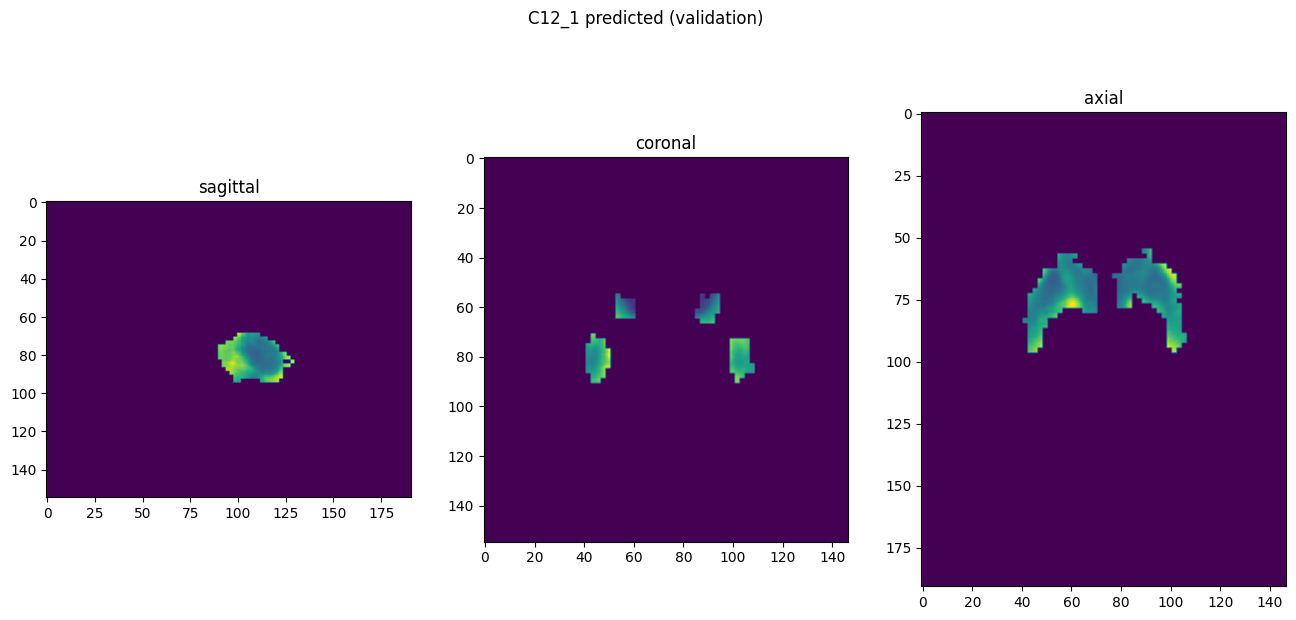

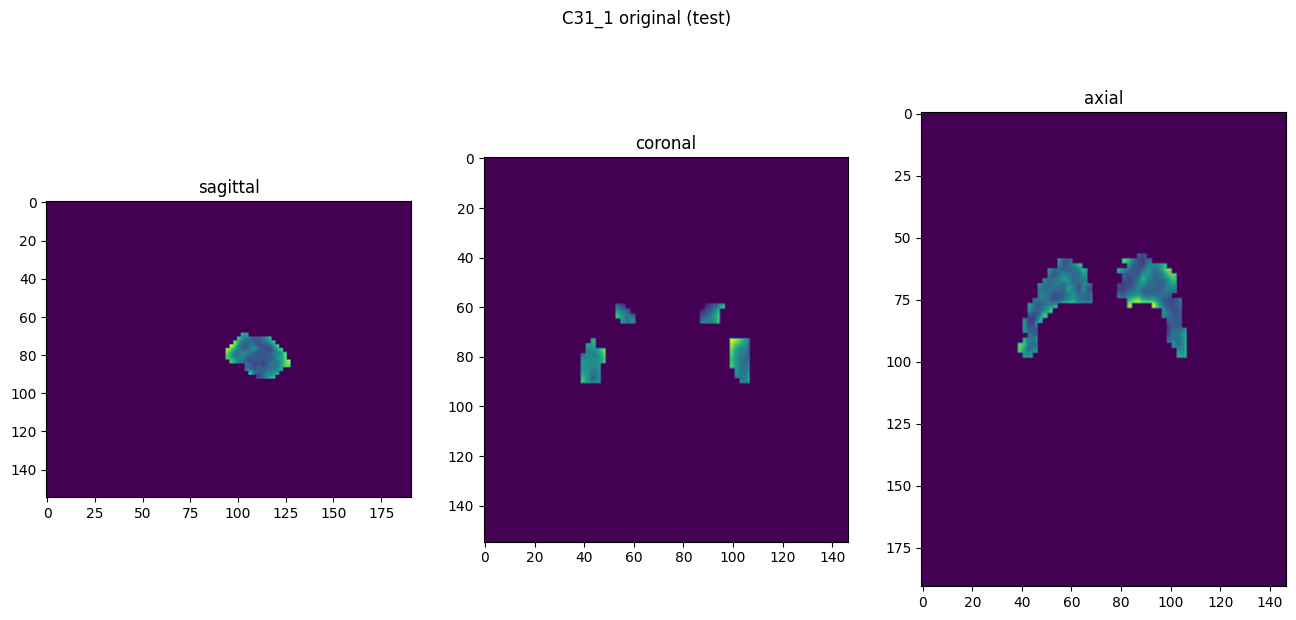

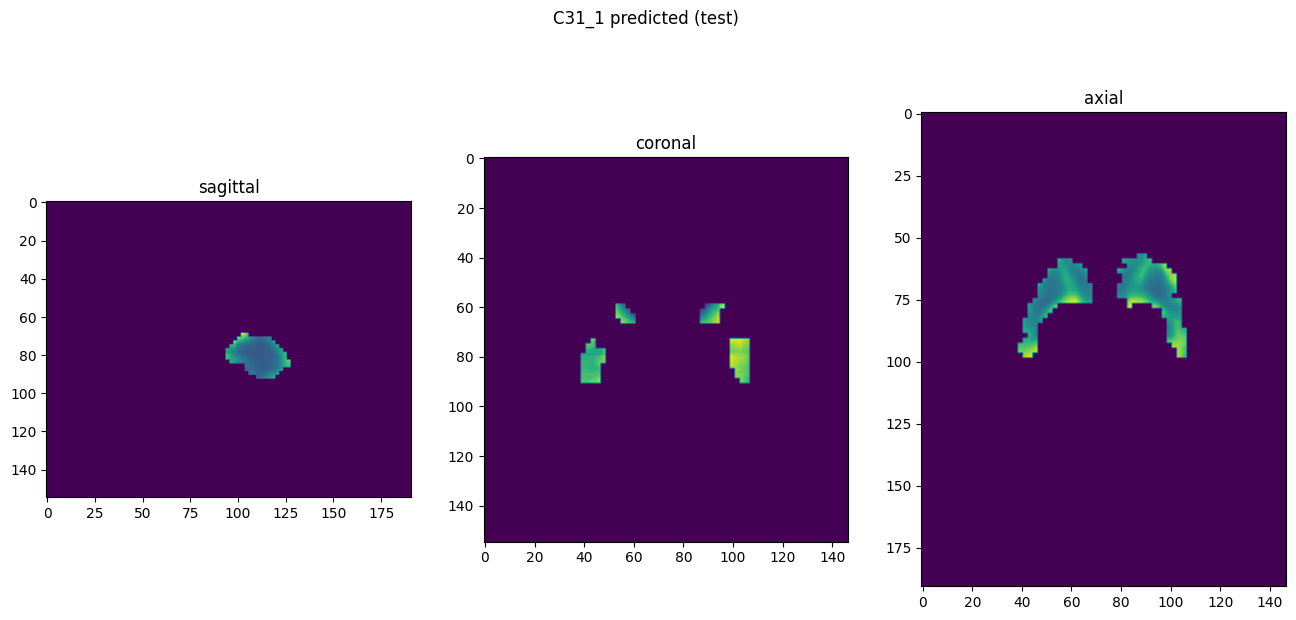

In [10]:
showResults(model, gen, threshold=None, background=False)